In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import dowhy
from dowhy import CausalModel
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

## First model: 
### Two common causes, a single treatment and a single outcome

In [3]:
# Simple model with two common causes, a single treatment and a single outcome

N_samples = 10000           # Number of samples
event_slope = 75 * 10       # Strength of the effect of the event on the outcome
week_days_slope = 500 * 5   # Strength of the effect of the week days on the outcome 
offer_slope = 150           # Strength of the effect of the offer on the outcome


# Generate the data
week_days = np.random.choice(np.arange(1, 6, 1), size=N_samples) / 5
event = np.random.uniform(0, 1, size=N_samples)
offer = np.zeros(N_samples)
total_sale = np.zeros(N_samples)

for i in range(N_samples):
    # Mondays to Wednesdays
    if week_days[i] < 4/5: 
        if event[i] > 0.5:   # Bigger event
            offer[i] = 1
        else:
            offer[i] = 0
        total_sale[i] = week_days_slope * week_days[i] + offer_slope * offer[i] + event_slope * event[i]

    # Mondays to Wednesdays
    elif week_days[i] < 4/5: 
        offer[i] = 0 
        total_sale[i] = week_days_slope * week_days[i] + event_slope * event[i]

    # Thursdays to Fridays
    elif week_days[i] >= 4/5: # Smaller event 
        if event[i] > 0.5:
            offer[i] = 0
        else:
            offer[i] = 1
        total_sale[i] = week_days_slope * week_days[i] + offer_slope * offer[i] + event_slope * event[i]

    # Thursdays to Fridays
    elif week_days[i] >= 4/5: 
        offer[i] = 0
        total_sale[i] = week_days_slope * week_days[i] + event_slope * event[i]

In [4]:
# Create a dictionary with the data
data = {'Week_days': week_days, 
        'Event': event,
        'Offer': offer, 
        'Total_sale': total_sale}

# Create a pandas dataframe
df = pd.DataFrame(data)
print(df.head())

# Define the DAG for the model
dag = """digraph {
        Week_days -> Offer;
        Week_days -> Total_sale;
        Event -> Total_sale;
        Event -> Offer;
        Offer -> Total_sale;
        }"""

# Create a causal model from the data and the DAG
model = CausalModel(data=df,
                    treatment='Offer',
                    outcome='Total_sale',
                    common_causes=['Week_days', 'Event'],
                    graph=dag)

   Week_days     Event  Offer   Total_sale
0        0.8  0.038592    1.0  2178.943671
1        1.0  0.878881    0.0  3159.160859
2        0.6  0.314933    0.0  1736.199921
3        1.0  0.128979    1.0  2746.734181
4        1.0  0.468461    1.0  3001.345928


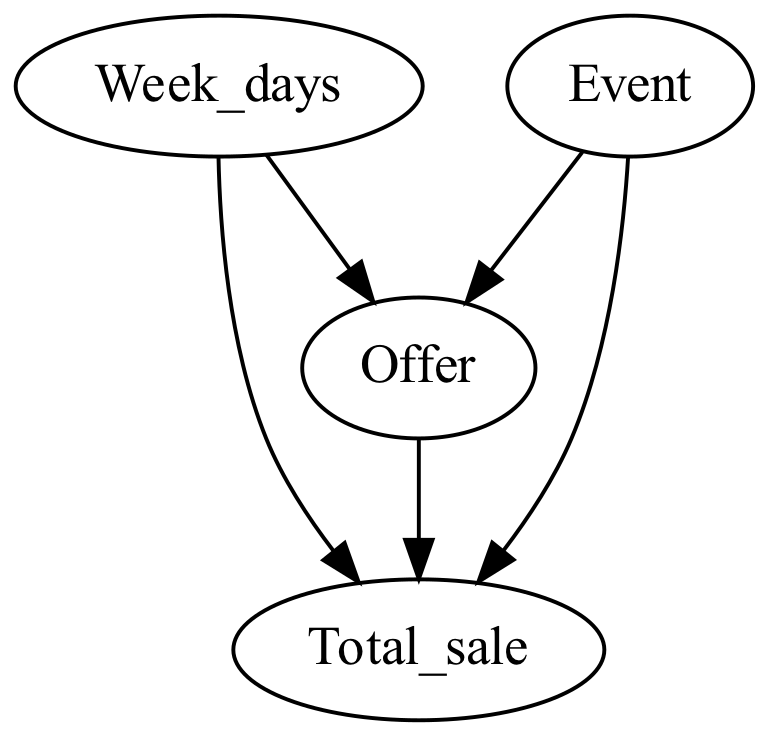

In [5]:
# View the causal graph
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

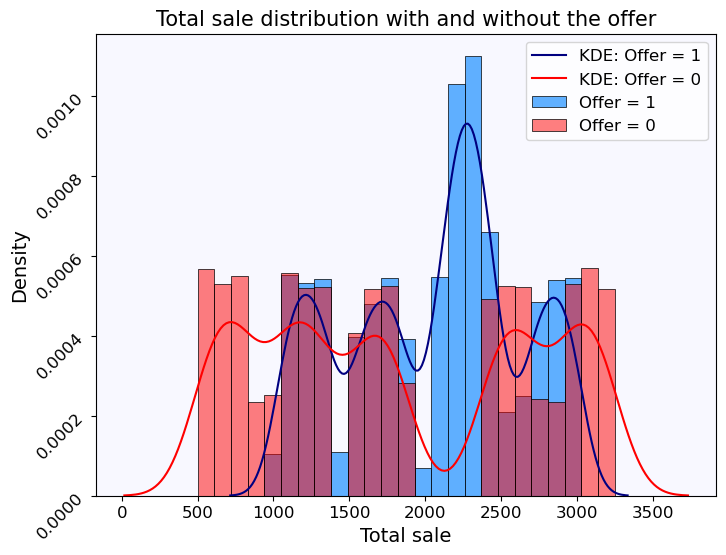

In [6]:
# Plot distributions of total sales with and without the offer
total_sales_with_offer = df[df['Offer'] == 1]['Total_sale']
total_sales_without_offer = df[df['Offer'] == 0]['Total_sale']
sale_range = (df['Total_sale'].min(), df['Total_sale'].max())

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.histplot(total_sales_with_offer, binrange=sale_range, bins=25, color='dodgerblue', linewidth=0.5,
             stat='density', alpha=0.7, label='Offer = 1')
sns.histplot(total_sales_without_offer, binrange=sale_range, bins=25, color='red', linewidth=0.5,
             stat='density', alpha=0.5, label='Offer = 0')
sns.kdeplot(total_sales_with_offer, color='navy', label='KDE: Offer = 1')
sns.kdeplot(total_sales_without_offer, color='red', label='KDE: Offer = 0')


ax.set_xlabel('Total sale', fontdict={'fontsize': 14})
ax.set_ylabel('Density', fontdict={'fontsize': 14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=45)
ax.set_title('Total sale distribution with and without the offer', fontdict={'fontsize': 15})
ax.set_facecolor('ghostwhite')
ax.legend(fontsize=12)
plt.show()

In [7]:
# Run a linear regression of the offer on the total sale
import statsmodels.api as sm

X = df['Offer'].astype(float)
y = df['Total_sale'].astype(float)

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()

# Display a more parsimonious results summary
print(ols.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1830.5590     10.507    174.215      0.000    1809.962    1851.156
Offer        229.7519     14.888     15.432      0.000     200.568     258.936


In [8]:
# Identifying the causal effect
identified_estimand = model.identify_effect() 

# Estimate the causal effect with backdoor adjustment and linear regression
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 target_units="ate")
print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                   
────────(E[Total_sale|Event,Week_days])
d[Offer]                               
Estimand assumption 1, Unconfoundedness: If U→{Offer} and U→Total_sale then P(Total_sale|Offer,Event,Week_days,U) = P(Total_sale|Offer,Event,Week_days)

## Realized estimand
b: Total_sale~Offer+Event+Week_days
Target units: ate

## Estimate
Mean value: 150.00000000000045



/Users/emiliejessen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

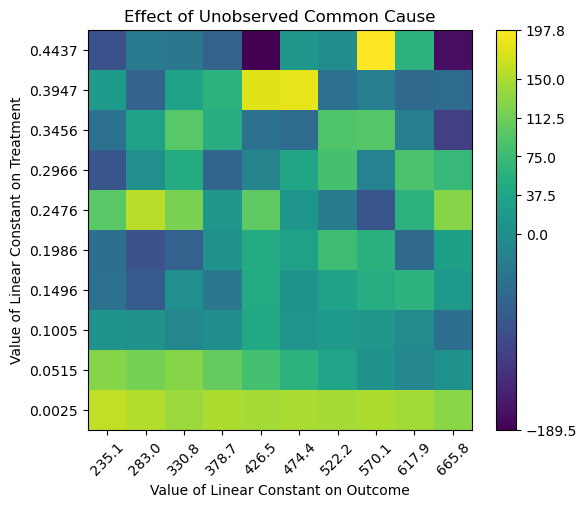

Refute: Add an Unobserved Common Cause
Estimated effect:150.00000000000045
New effect:(-189.4944570177288, 197.76659613446373)



In [9]:
# Check robustness of obtained estimate by adding unobserved confounders
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="add_unobserved_common_cause", 
                                       confounders_effect_on_treatment="binary_flip", 
                                       confounders_effect_on_outcome="linear",)
print(refute_results)

## Second model: 
### Two common causes, an instrumental variable, a single treatment and a single outcome

In [11]:
# Simple model with two common causes, a single treatment and a single outcome
# Now we add an instrumental variable

# Create the data with same slope values
week_days = np.random.choice(np.arange(1, 6, 1), size=N_samples)
stock = np.random.uniform(0, 1, size=N_samples)  # Instrumental variable
event = np.random.uniform(0, 10, size=N_samples)
offer = np.zeros(N_samples)
total_sale = np.zeros(N_samples)

for i in range(N_samples):
    # Mondays to Wednesdays and high stock
    if week_days[i] < 4 and stock[i] > 0.5:
        if event[i] > 5:  # Bigger event
            offer[i] = 1
        else:
            offer[i] = 0
        total_sale[i] = week_days_slope * week_days[i] + offer_slope * offer[i] + event_slope * event[i]

    # Mondays to Wednesdays and low stock
    elif week_days[i] < 4 and stock[i] <= 0.5:
        offer[i] = 0 
        total_sale[i] = week_days_slope * week_days[i] + event_slope * event[i]

    # Thursdays to Fridays and high stock
    elif week_days[i] >= 4 and stock[i] > 0.5:
        if event[i] > 5:
            offer[i] = 0
        else:
            offer[i] = 1
        total_sale[i] = week_days_slope * week_days[i] + offer_slope * offer[i] + event_slope * event[i]

    # Thursdays to Fridays and low stock
    elif week_days[i] >= 4 and stock[i] <= 0.5:
        offer[i] = 0
        total_sale[i] = week_days_slope * week_days[i] + event_slope * event[i]

In [12]:
# Create a dictionary with the data
data = {'Week_days': week_days, 
        'Stock': stock,
        'Event': event,
        'Offer': offer, 
        'Total_sale': total_sale}

# Create a pandas dataframe
df = pd.DataFrame(data)
print(df.head())

# Define the DAG for the model
dag = """digraph {
        Week_days -> Offer;
        Week_days -> Total_sale;
        Event -> Total_sale;
        Event -> Offer;
        Stock -> Offer;
        Offer -> Total_sale;
        }"""

model = CausalModel(data=df,
                    treatment='Offer',
                    outcome='Total_sale',
                    instruments=['Stock'],
                    common_causes=['Week_days', 'Event'],
                    graph=dag)

   Week_days     Stock     Event  Offer    Total_sale
0          1  0.683376  1.591098    0.0   3693.323189
1          3  0.083621  0.721094    0.0   8040.820635
2          5  0.402537  6.698015    0.0  17523.511206
3          2  0.769000  5.628984    1.0   9371.737980
4          1  0.119018  9.799775    0.0   9849.831140


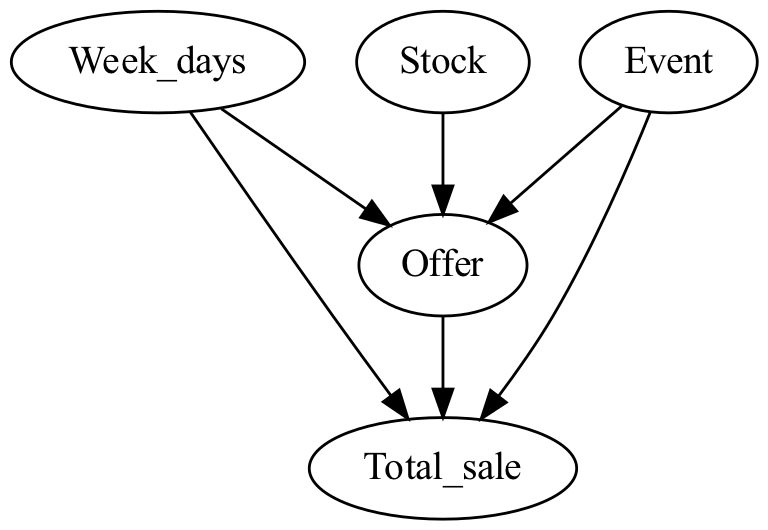

In [13]:
# View the causal graph
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [14]:
import networkx as nx
from dowhy.gcm import falsify
graph = nx.DiGraph()

# Add nodes to the graph
graph.add_nodes_from(['Week_days', 'Stock', 'Event', 'Offer', 'Total_sale'])

# Add edges to the graph
graph.add_edges_from([('Week_days', 'Offer'), ('Week_days', 'Total_sale'), ('Stock', 'Offer'),
                      ('Event', 'Offer'), ('Event', 'Total_sale'),
                      ('Offer', 'Total_sale')])

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=3000, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)
plt.show()

a = falsify.validate_lmc(graph , df)
print(a)

c=falsify.falsify_graph(graph , df)
print(c)

ImportError: cannot import name 'falsify' from 'dowhy.gcm' (/Users/emiliejessen/opt/anaconda3/lib/python3.8/site-packages/dowhy/gcm/__init__.py)

## Complex model

In [4]:
# Generate data for complex model with offer 

num_samples = 10000

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
Offer = np.array([1, 1.1 , 1.5 , 1.9, 2.1])
day_data_with_offer = []
beer_sale_data_with_offer = []
beer_pr_sale_data_with_offer = []
number_of_sales_data_with_offer = []
customers_data_with_offer = []

for i,day in enumerate(days_of_week):
    if day == 'Monday':
        customers = np.random.randint(50, 100, num_samples)
    elif day == 'Tuesday':
        customers = np.random.randint(80, 150, num_samples)
    elif day == 'Wednesday':
        customers = np.random.randint(150, 300, num_samples)
    elif day == 'Thursday':
        customers = np.random.randint(300, 600, num_samples)
    elif day == 'Friday':
        customers = np.random.randint(600, 1200, num_samples)
    
    # Extend the customers_data list
    

    beer_pr_sale = np.random.normal(2, 1, num_samples) * Offer[i] + np.random.normal(0,0.5, num_samples)

    number_of_sales = customers - customers*(0.1)* beer_pr_sale - Offer[i]*0.1 + np.random.normal(0,10, num_samples)

    beer_sale_tot = beer_pr_sale * number_of_sales 

    mask_tot  = beer_sale_tot > 0
    
    beer_sale_tot = beer_sale_tot[mask_tot]
    beer_pr_sale = beer_pr_sale[mask_tot]
    number_of_sales = number_of_sales[mask_tot]
    customers = customers[mask_tot]

    day_data_with_offer.extend([day] * len(beer_sale_tot))

    beer_sale_data_with_offer.extend(beer_sale_tot)
    beer_pr_sale_data_with_offer.extend(beer_pr_sale)
    number_of_sales_data_with_offer.extend(number_of_sales)
    customers_data_with_offer.extend(customers)

#Convert to pandas dataframe
offer_given = np.random.choice([1], size=len(day_data_with_offer))
data1 = {
    'Day': day_data_with_offer,
    'Customers': customers_data_with_offer,
    'Total_sale': beer_sale_data_with_offer,
    'Beer_pr_sale': beer_pr_sale_data_with_offer,
    'Number_of_Sales': number_of_sales_data_with_offer,
    'Offer': offer_given
}
df1 = pd.DataFrame(data1)

In [5]:
# Generate data for complex model without offer

day_data = []
beer_sale_data = []
beer_pr_sale_data = []
number_of_sales_data = []
customers_data = []
for i,day in enumerate(days_of_week):
    if day == 'Monday':
        customers = np.random.randint(50, 100, num_samples)
    elif day == 'Tuesday':
        customers = np.random.randint(80, 150, num_samples)
    elif day == 'Wednesday':
        customers = np.random.randint(150, 300, num_samples)
    elif day == 'Thursday':
        customers = np.random.randint(300, 600, num_samples)
    elif day == 'Friday':
        customers = np.random.randint(600, 1200, num_samples)
    
    # Extend the customers_data list
    
    beer_pr_sale = np.random.normal(2, 1, num_samples) +  np.random.normal(0,0.5, num_samples)

    number_of_sales = customers - customers*(0.1)* beer_pr_sale + np.random.normal(0,10, num_samples)

    beer_sale_tot = beer_pr_sale * number_of_sales + np.random.normal(0, 1, num_samples)
    

    mask_tot  = beer_sale_tot > 0
    
    beer_sale_tot = beer_sale_tot[mask_tot]
    beer_pr_sale = beer_pr_sale[mask_tot]
    number_of_sales = number_of_sales[mask_tot]
    customers = customers[mask_tot]
    day_data.extend([day] * len(beer_sale_tot))

    beer_sale_data.extend(beer_sale_tot)
    beer_pr_sale_data.extend(beer_pr_sale)
    number_of_sales_data.extend(number_of_sales)
    customers_data.extend(customers)
    
#Convert to pandas dataframe
offer_given = np.random.choice([0], size=len(day_data))
print(offer_given)
data = {
    'Day': day_data,
    'Customers' : customers_data,
    'Total_sale': beer_sale_data,
    'Beer_pr_sale': beer_pr_sale_data,
    'Number_of_Sales': number_of_sales_data,
    'Offer': offer_given
}
df = pd.DataFrame(data)

# Display the DataFrame
combined_df = pd.concat([df, df1],ignore_index=True)
print(combined_df)

[0 0 0 ... 0 0 0]
          Day  Customers   Total_sale  Beer_pr_sale  Number_of_Sales  Offer
0      Monday         60   122.630418      2.189177        56.087804      0
1      Monday         53    36.405103      0.710712        49.951611      0
2      Monday         72    58.687598      0.928962        62.503827      0
3      Monday         81   161.481521      2.201667        73.906878      0
4      Monday         95     3.511602      0.053184        89.351789      0
...       ...        ...          ...           ...              ...    ...
96591  Friday        978  1828.358248      2.414486       757.245402      1
96592  Friday        947  2341.016427      5.338910       438.482058      1
96593  Friday        972  2175.626298      3.474341       626.198277      1
96594  Friday        912  2206.263128      4.249631       519.165756      1
96595  Friday        715  1146.091679      8.066750       142.076018      1

[96596 rows x 6 columns]


In [6]:
model = CausalModel(
    data=combined_df,
    treatment='Offer',
    outcome='Total_sale',
      graph="""digraph {
        Day -> Offer;
        Offer -> Beer_pr_sale;
        Offer -> Number_of_Sales;
        Beer_pr_sale -> Number_of_Sales;
        Beer_pr_sale -> Total_sale;
        Number_of_Sales -> Total_sale;
        Day -> Customers;
        Customers -> Total_sale;
        Customers -> Number_of_Sales;
        }"""
)

In [7]:
identified_estimand = model.identify_effect()

bd_estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

ps_estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_matching")

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['Customers']}


ValueError: shapes (19552,4) and (7,) not aligned: 4 (dim 1) != 7 (dim 0)

In [29]:
print(bd_estimate.value, ps_estimate.value)

NameError: name 'bd_estimate' is not defined

In [22]:
# Change offer to random variable

df2 = combined_df
df2['Offer'] = np.random.choice([0,1], size=len(combined_df['Offer']))

# Creating a causal model
model1 = CausalModel(
    data=df2,
    treatment='Offer',
    outcome='Total_sale',
      graph="""digraph {
        Day -> Offer;
        Offer -> Beer_pr_sale;
        Offer -> Number_of_Sales;
        Beer_pr_sale -> Number_of_Sales;
        Beer_pr_sale -> Total_sale;
        Number_of_Sales -> Total_sale;
        Day -> Customers;
        Customers -> Total_sale;
        Customers -> Number_of_Sales;
        }"""
)

# Identify the causal effect
identified_estimand = model1.identify_effect()

bd_estimate_ran = model1.estimate_effect(identified_estimand,
                                 confidence_intervals=False,
                                 method_name="backdoor.linear_regression")

ps_estimate_ran = model1.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_matching")

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['Customers']}


ValueError: shapes (19548,4) and (7,) not aligned: 4 (dim 1) != 7 (dim 0)

In [ ]:
print(bd_estimate_ran.value, ps_estimate_ran.value)

-1.0322484697852587
-2.135129939664015
